In [1]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [2]:
from laos_gggi import load_all_data

# Data

In [3]:
#Load data
data = load_all_data()

#Load time series
time_series = data["df_time_series"]

In [4]:
#Total events around the world
total_events_world =  (data["emdat_events"].sum(axis = 1).reset_index().rename(columns = {0: "Total_events"})
 .pivot_table(values= "Total_events",  index = "Start_Year", aggfunc= "sum")).iloc[ 2: ,  ].reset_index()

total_events_world["Start_Year"] = pd.to_datetime(total_events_world["Start_Year"], format='%Y')
total_events_world = total_events_world.set_index("Start_Year")


#Total events around the world
total_damages_world = (data["emdat_damage"].sum(axis = 1).reset_index().rename(columns = {0: "Total_damages"})
 .pivot_table(values= "Total_damages",  index = "Start_Year", aggfunc= "sum")).iloc[ 2: ,  ].reset_index()

total_damages_world["Start_Year"] = pd.to_datetime(total_damages_world["Start_Year"], format='%Y')
total_damages_world = total_damages_world.set_index("Start_Year")


#Total number of floods
total_floods_world = ( data["emdat_events"].reset_index()[["Flood", "ISO", "Start_Year"]]
                     .pivot_table(values= "Flood",  index = "Start_Year", aggfunc= "sum").iloc[ 2: ,  ].reset_index())

total_floods_world["Start_Year"] = pd.to_datetime(total_floods_world["Start_Year"], format='%Y')
total_floods_world = total_floods_world.set_index("Start_Year")

# Utilities

In [5]:
#Determine the number of lags for ACF and PACF
from laos_gggi.statistics import ADF_test_summary
nlags= 10

# Introduction

This notebook realizes a time series analysis of the main time series variables to use in the model.

As a general conclusion, it is clear that the series have a time trend that must be removed to model their relationships. Therefore the model should not use the level versions of the variables, as we would find spurious correlations. When de-trending all the time series, the ADF tests allow us to reject the unit root null hypothesis. Therefore we can conclude the de-trended versions of the series are stationary and can be used for modeling.

In the case of cointegration, we applied the Johansen cointegration test and we rejected the null hypothesis of cointegration among variables. We also applied the Engle and Granger test to evaluate cointegration between variables pairs, the results rejected the cointegration null hypothesis for all cases.

# Ocean temperature

## Seasonal-trend decomposition 

In [7]:
stl_ocean_temp = STL( pd.DataFrame(time_series["Temp"].dropna()), period = 3)
result_ocean_temp = stl_ocean_temp.fit()

In [8]:
trend_ocean_temp, seasonal_ocean_temp, resid_ocean_temp = result_ocean_temp.trend, result_ocean_temp.seasonal,  result_ocean_temp.resid

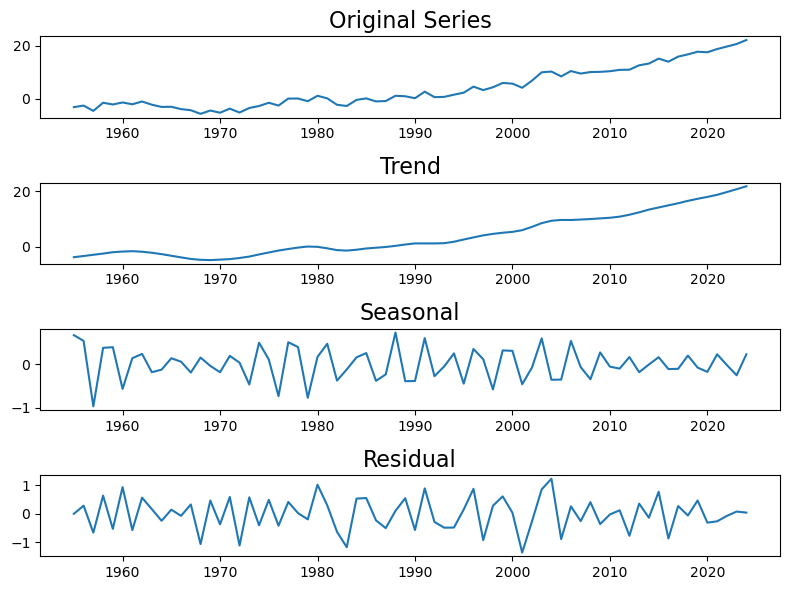

In [9]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(time_series["Temp"].dropna())
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend_ocean_temp)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal_ocean_temp)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid_ocean_temp)
plt.title('Residual', fontsize=16)

plt.tight_layout( )

## Remove trend

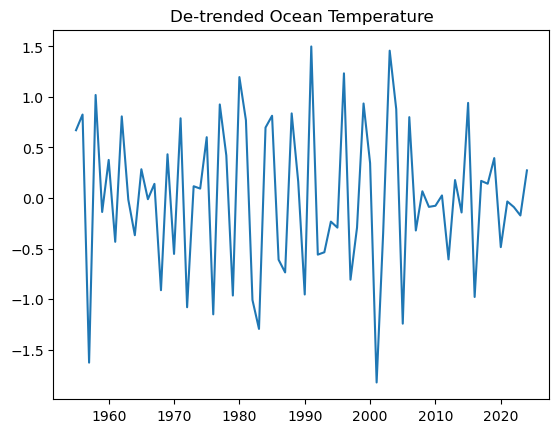

In [10]:
#Obtain de-trended
detrended_ocean_temp = time_series["Temp"].dropna() - trend_ocean_temp

plt.plot(detrended_ocean_temp)
plt.title("De-trended Ocean Temperature");

## ACF and PACF

Now we obtain the ACF and PACF for the de-trended series

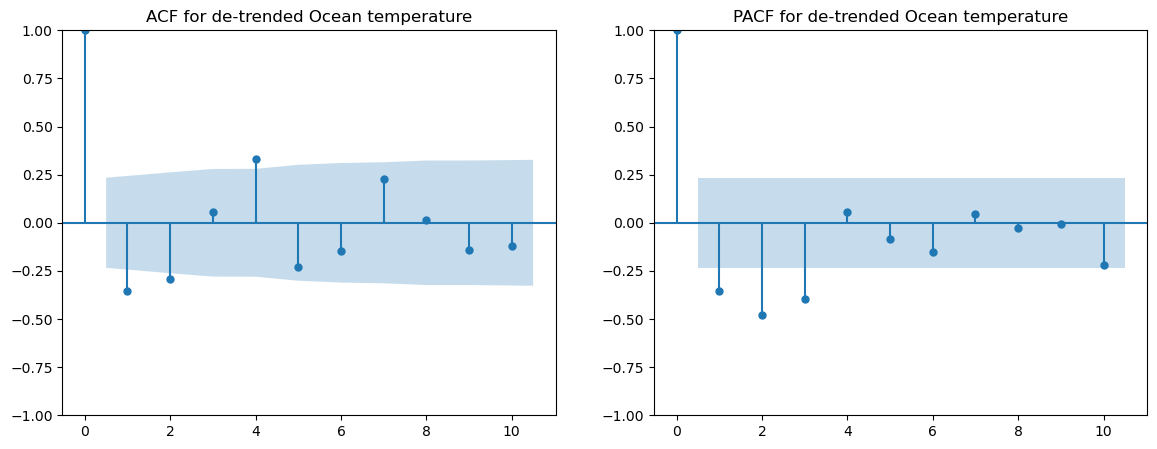

In [11]:
fig, ax= plt.subplots(1, 2, figsize = (14,5))
acf_plot = plot_acf(detrended_ocean_temp, lags = nlags, ax= ax[0])
ax[0].set_title("ACF for de-trended Ocean temperature")

acf_plot = plot_pacf(detrended_ocean_temp, lags = nlags, ax= ax[1])
ax[1].set_title("PACF for de-trended Ocean temperature");

## Augmented Dickey Fuller test

By applying the Augmented Dickey-Fuller test to the de-trended version of the ocean temperature, we reject the null hypothesis of unit root presence, and we can assume stationarity.

In [12]:
ADF_test_summary( pd.DataFrame(detrended_ocean_temp).dropna().rename(columns={ 0: "Events"}))

                                                    Events                                                    
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -2.819        -10.043        0.000          2    -4.101      -3.478     -3.167
	Constant             0.080          0.579        0.565
	Trend               -0.003         -0.765        0.447
Constant Only               -2.807        -10.049        0.000          2    -3.532      -2.906     -2.590
	Constant            -0.012         -0.175        0.862
No Constant                 -2.805        -10.125        0.000          2    -2.600      -1.946     -1.613


## Seasonality analysis

In [13]:
detrended_ocean_temp= detrended_ocean_temp.reset_index().rename(columns = {0 : "Ocean_temperature"})

In [14]:
#Identify the segments of the 3 year cycle
firsts = []
y = 1955
for x in range(1,25):
    firsts.append(y)
    y = y +3

seconds = []
y = 1956
for x in range(1,24):
    seconds.append(y)
    y = y +3

thirds = []
y = 1957
for x in range(1,24):
    thirds.append(y)
    y = y +3


In [15]:
#Obtain the section of the period 
for x in detrended_ocean_temp.index:
    if detrended_ocean_temp.loc[x, "year"] in firsts:
        detrended_ocean_temp.loc[x, "cycle_segment"] = 1

    if detrended_ocean_temp.loc[x, "year"] in seconds:
        detrended_ocean_temp.loc[x, "cycle_segment"] = 2
        
    if detrended_ocean_temp.loc[x, "year"] in thirds:
         detrended_ocean_temp.loc[x, "cycle_segment"] = 3       


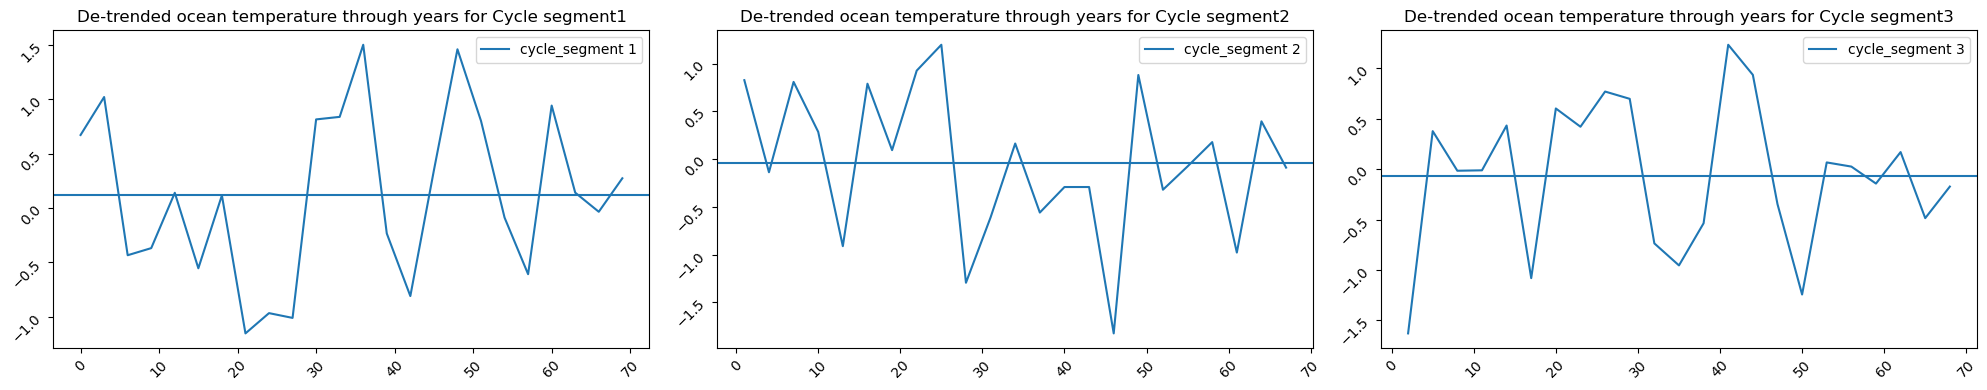

In [16]:
figure, axis = plt.subplots(1, 3, figsize=(20, 4)) 

for x in [1,2,3]:
    axis[x-1].plot(detrended_ocean_temp.query('cycle_segment == @x')["Ocean_temperature"] )
    axis[x-1].tick_params(labelrotation=45)
    axis[x-1].axhline(y = detrended_ocean_temp.query('cycle_segment == @x')["Ocean_temperature"].mean(), label = f"cycle_segment {x}")
    axis[x-1].set_title( "De-trended ocean temperature through years for Cycle segment" + str(x) )
    axis[x-1].legend()

plt.legend()
plt.tight_layout()

period_length is 3


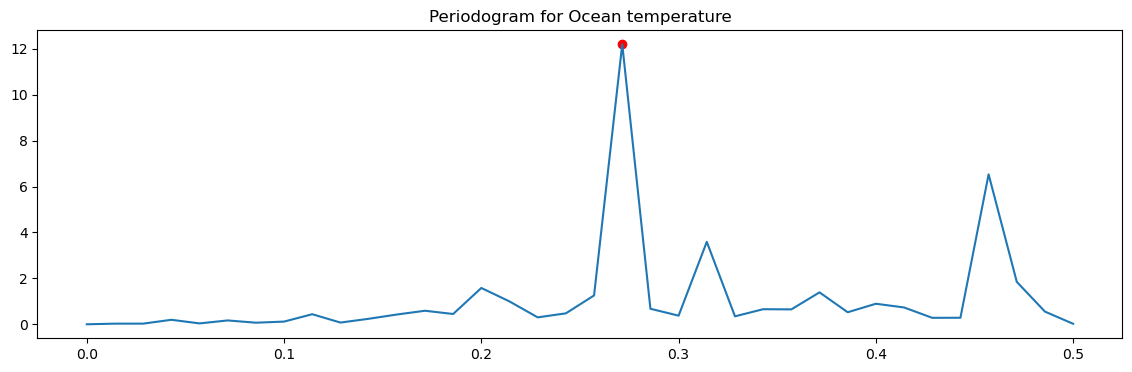

In [17]:
#Periodogram
f, Pxx = scipy.signal.periodogram(detrended_ocean_temp["Ocean_temperature"])
max_power_index = np.argmax(Pxx)
dominant_frequency = f[max_power_index]
period_length = int(1 / dominant_frequency)

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(f, Pxx, label='Periodogram')
ax.scatter(f[max_power_index], Pxx[max_power_index], color='red', label=f'Dominant Frequency: {dominant_frequency:.2f} Hz')
plt.title("Periodogram for Ocean temperature");

print("period_length is " +str(period_length))

# Co2 emissions

## Seasonal-trend decomposition 

In [18]:
stl_co2 = STL(time_series["co2"].dropna(), period = 3)
result_co2 = stl_co2.fit()

In [19]:
trend_co2, seasonal_co2, resid_co2 = result_co2.trend, result_co2.seasonal,  result_co2.resid

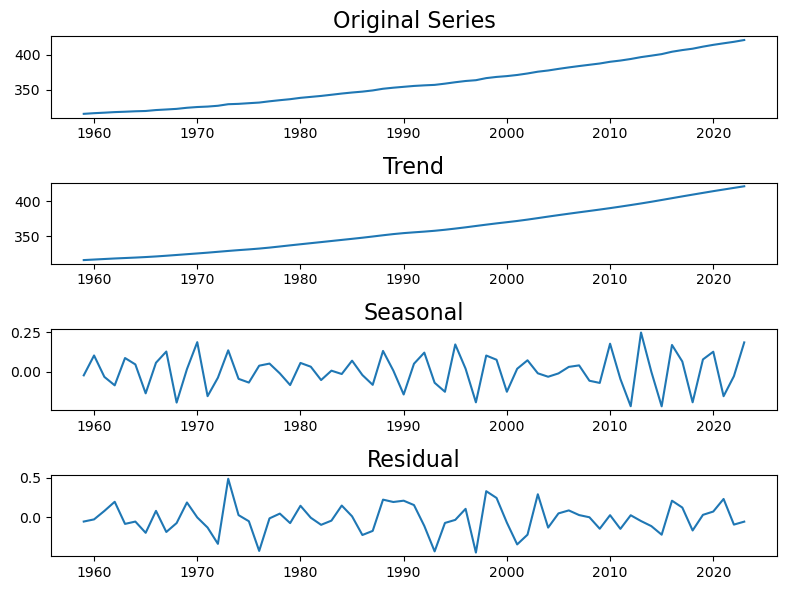

In [20]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(time_series["co2"])
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend_co2)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal_co2)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid_co2)
plt.title('Residual', fontsize=16)

plt.tight_layout( )

## Remove trend

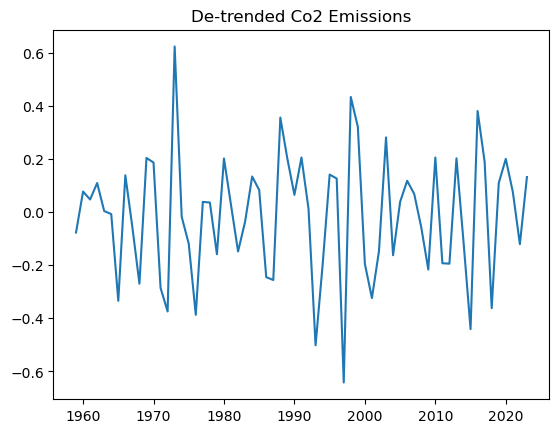

In [21]:
#Obtain de-trended
detrended_co2 = time_series["co2"] - trend_co2

plt.plot(detrended_co2)
plt.title("De-trended Co2 Emissions");

## ACF and PACF

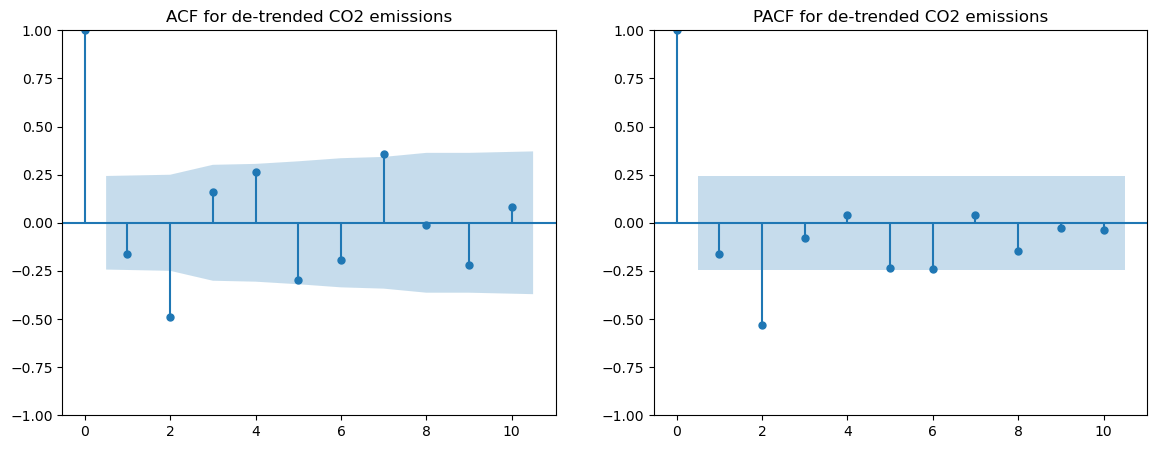

In [22]:
fig, ax= plt.subplots(1, 2, figsize = (14,5))
acf_plot = plot_acf(detrended_co2.dropna(), lags = nlags, ax=ax[0])
ax[0].set_title("ACF for de-trended CO2 emissions")

pacf_plot = plot_pacf(detrended_co2.dropna(), lags = nlags, ax = ax[1])
ax[1].set_title("PACF for de-trended CO2 emissions");

## Augmented Dickey Fuller test

By applying the Augmented Dickey-Fuller test to the de-trended version of the ocean CO2 emissions, we reject the null hypothesis of unit root presence, and we can assume stationarity.

In [23]:
ADF_test_summary( pd.DataFrame(detrended_co2).dropna().rename(columns={ 0: "Events"}))

                                                    Events                                                    
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -1.786        -10.635        0.000          1    -4.110      -3.483     -3.169
	Constant            -0.041         -0.778        0.440
	Trend                0.001          0.362        0.719
Constant Only               -1.785        -10.708        0.000          1    -3.539      -2.909     -2.592
	Constant            -0.025         -0.943        0.350
No Constant                 -1.771        -10.677        0.000          1    -2.602      -1.946     -1.613


## Seasonality analysis

In [24]:
detrended_co2= detrended_co2.reset_index().rename(columns = {0 : "Co2"})

In [25]:
#Obtain the section of the period 
for x in detrended_co2.index:
    if detrended_co2.loc[x, "year"] in firsts:
        detrended_co2.loc[x, "cycle_segment"] = 1

    if detrended_co2.loc[x, "year"] in seconds:
        detrended_co2.loc[x, "cycle_segment"] = 2
        
    if detrended_co2.loc[x, "year"] in thirds:
         detrended_co2.loc[x, "cycle_segment"] = 3       


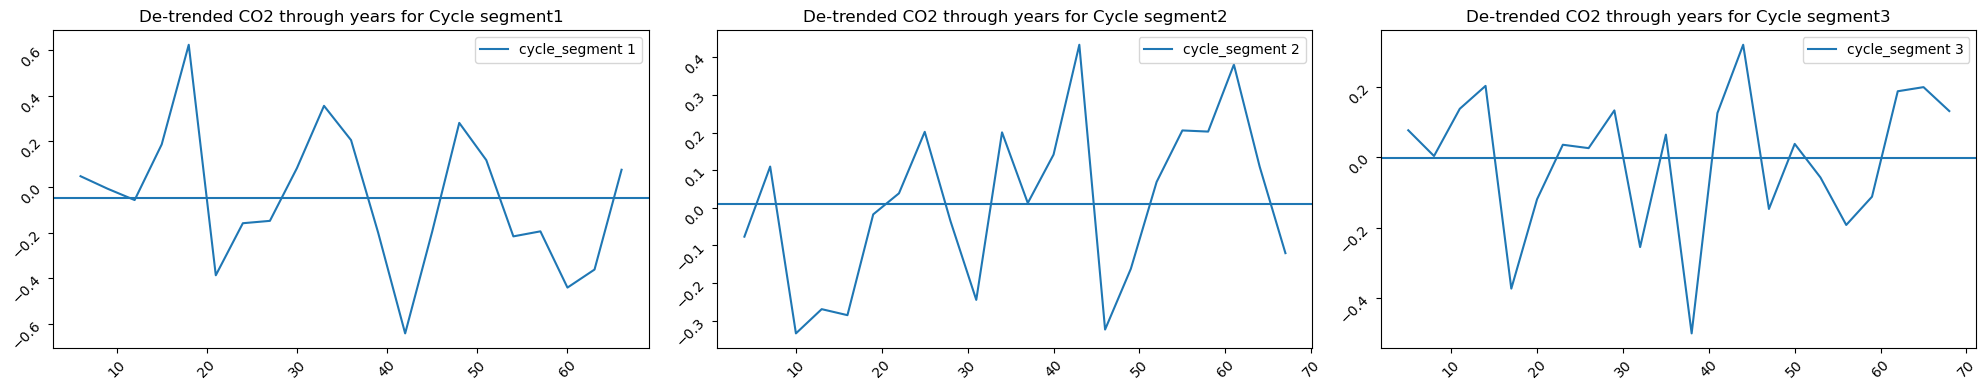

In [26]:
figure, axis = plt.subplots(1, 3, figsize=(20, 4)) 

for x in [1,2,3]:
    axis[x-1].plot(detrended_co2.query('cycle_segment == @x')["Co2"] )
    axis[x-1].tick_params(labelrotation=45)
    axis[x-1].axhline(y = detrended_co2.query('cycle_segment == @x')["Co2"].mean(), label = f"cycle_segment {x}")
    axis[x-1].set_title( "De-trended CO2 through years for Cycle segment" + str(x) )
    axis[x-1].legend()

plt.legend()
plt.tight_layout()

period_length is 3


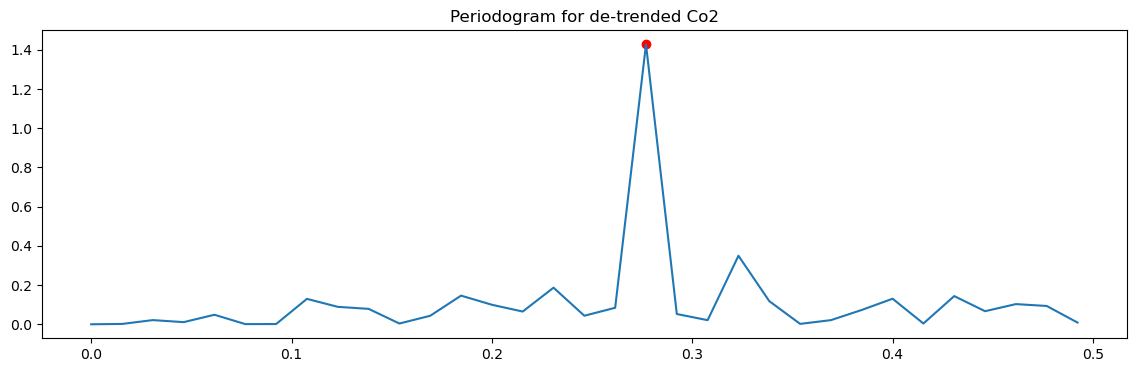

In [27]:
#Periodogram
f, Pxx = scipy.signal.periodogram(detrended_co2["Co2"].dropna())
max_power_index = np.argmax(Pxx)
dominant_frequency = f[max_power_index]
period_length = int(1 / dominant_frequency)

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(f, Pxx, label='Periodogram')
ax.scatter(f[max_power_index], Pxx[max_power_index], color='red', label=f'Dominant Frequency: {dominant_frequency:.2f} Hz')
plt.title("Periodogram for de-trended Co2");
print("period_length is " +str(period_length))

# World precipitation

## Seasonal-trend decomposition 

In [28]:
stl_precip = STL(time_series["precip"].dropna(), period = 3)
result_precip = stl_precip.fit()

In [29]:
trend_precip, seasonal_precip, resid_precip = result_precip.trend, result_precip.seasonal,  result_precip.resid

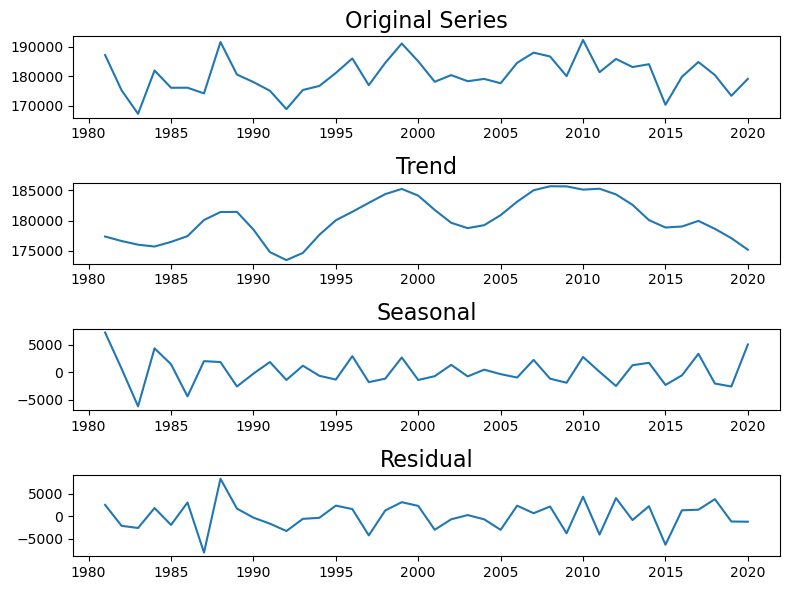

In [30]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(time_series["precip"])
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend_precip)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal_precip)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid_precip)
plt.title('Residual', fontsize=16)

plt.tight_layout( )

## Remove trend

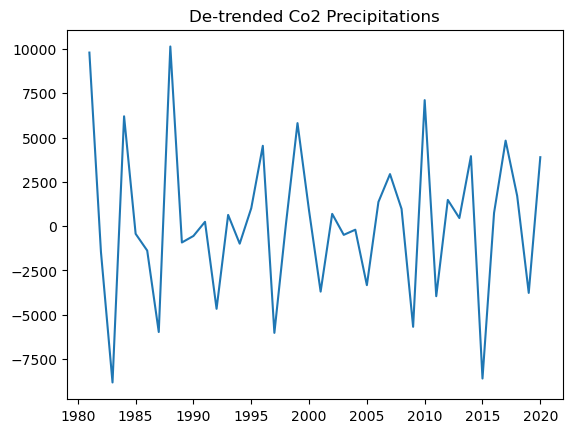

In [31]:
#Obtain de-trended
detrended_precip = time_series["precip"] - trend_precip

plt.plot(detrended_precip)
plt.title("De-trended Co2 Precipitations");

## ACF and PACF

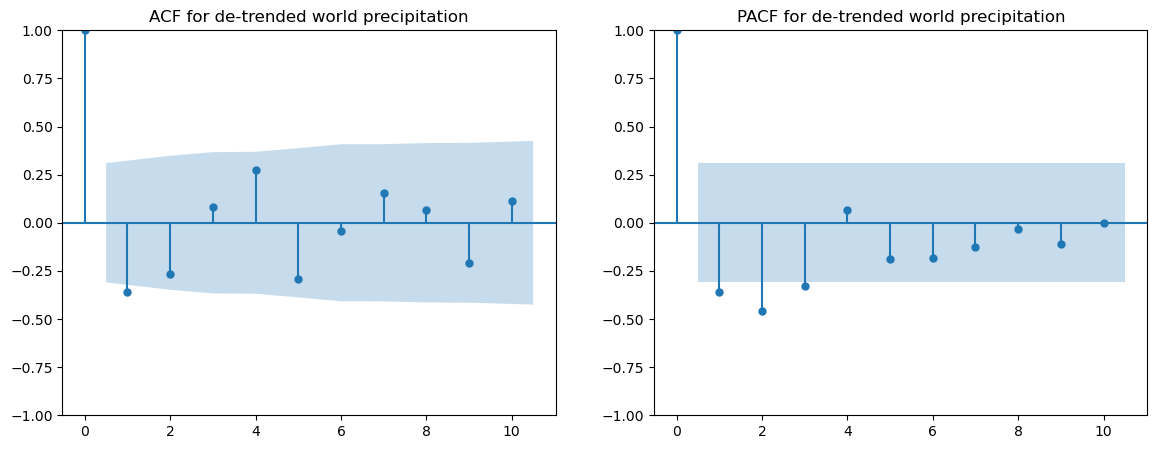

In [32]:
fig, ax= plt.subplots(1, 2, figsize = (14,5))
acf_plot = plot_acf(detrended_precip.dropna(), lags = nlags, ax = ax[0])
ax[0].set_title("ACF for de-trended world precipitation");

pacf_plot = plot_pacf(detrended_precip.dropna(), lags = nlags, ax = ax[1])
ax[1].set_title("PACF for de-trended world precipitation");

## Augmented Dickey Fuller test

By applying the Augmented Dickey-Fuller test to the de-trended version of precipitation, we reject the null hypothesis of unit root presence, and we can assume stationarity. In this case, we use the constant specification

In [33]:
ADF_test_summary(time_series["precip"].dropna())

                                                    precip                                                    
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.852         -5.329        0.000          0    -4.212      -3.530     -3.196
	Constant        151085.793          5.295        0.000
	Trend              122.344          1.462        0.152
Constant Only               -0.800         -5.055        0.000          0    -3.610      -2.939     -2.608
	Constant        144073.318          5.045        0.000
No Constant                 -0.001         -0.108        0.647          1    -2.627      -1.950     -1.611


## Seasonality analysis

In [34]:
detrended_precip= detrended_precip.reset_index().rename(columns = {0 : "precip"})

In [35]:
#Obtain the section of the period 
for x in detrended_precip.index:
    if detrended_precip.loc[x, "year"] in firsts:
        detrended_precip.loc[x, "cycle_segment"] = 1

    if detrended_precip.loc[x, "year"] in seconds:
        detrended_precip.loc[x, "cycle_segment"] = 2
        
    if detrended_precip.loc[x, "year"] in thirds:
         detrended_precip.loc[x, "cycle_segment"] = 3       


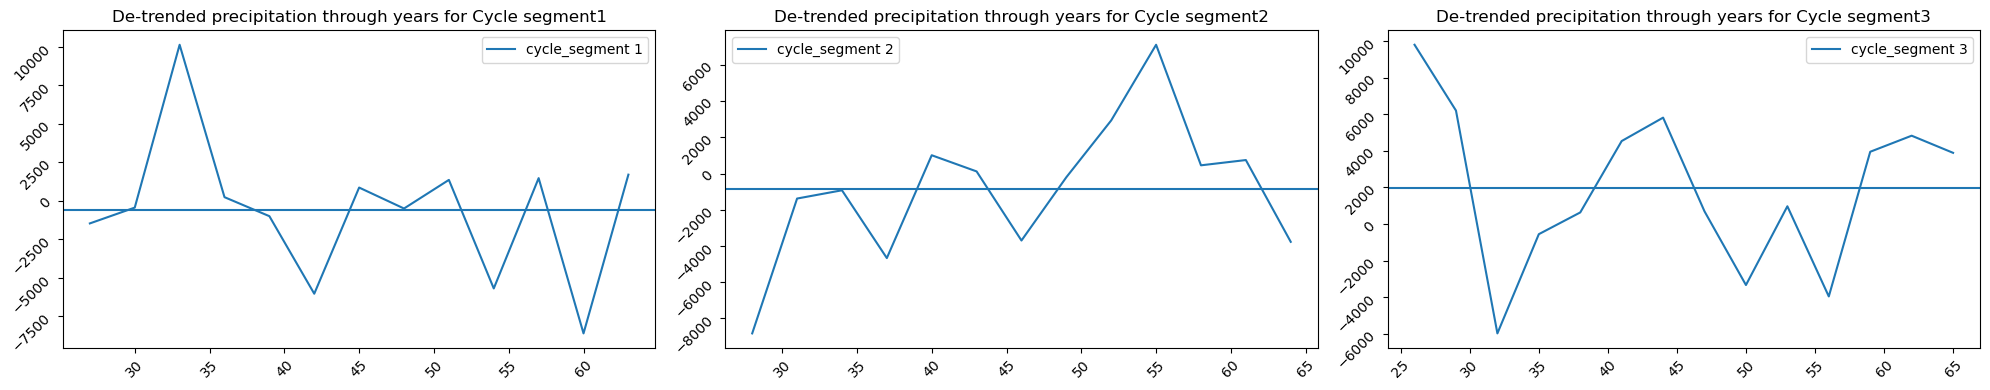

In [36]:
figure, axis = plt.subplots(1, 3, figsize=(20, 4)) 

for x in [1,2,3]:
    axis[x-1].plot(detrended_precip.query('cycle_segment == @x')["precip"] )
    axis[x-1].tick_params(labelrotation=45)
    axis[x-1].axhline(y = detrended_precip.query('cycle_segment == @x')["precip"].mean(), label = f"cycle_segment {x}")
    axis[x-1].set_title( "De-trended precipitation through years for Cycle segment" + str(x) )
    axis[x-1].legend()

plt.legend()
plt.tight_layout()

period_length is 3


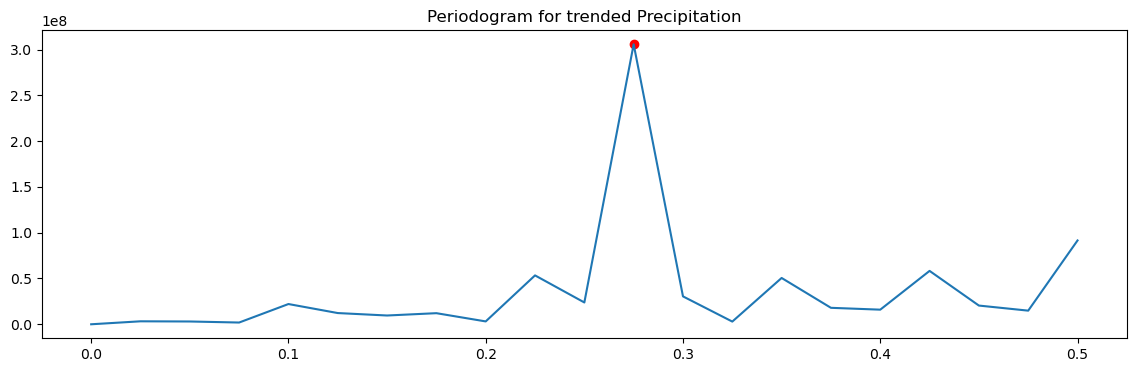

In [37]:
#Periodogram
f, Pxx = scipy.signal.periodogram(detrended_precip["precip"].dropna())
max_power_index = np.argmax(Pxx)
dominant_frequency = f[max_power_index]
period_length = int(1 / dominant_frequency)

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(f, Pxx, label='Periodogram')
ax.scatter(f[max_power_index], Pxx[max_power_index], color='red', label=f'Dominant Frequency: {dominant_frequency:.2f} Hz')
plt.title("Periodogram for trended Precipitation");
print("period_length is " +str(period_length))

# Total disasters reported around the world

## Seasonal-trend decomposition 

In [38]:
stl_events = STL( total_events_world.dropna().astype("int"), period = 2)
result_events = stl_events.fit()

In [39]:
trend_events, seasonal_events, resid_events = result_events.trend, result_events.seasonal,  result_events.resid

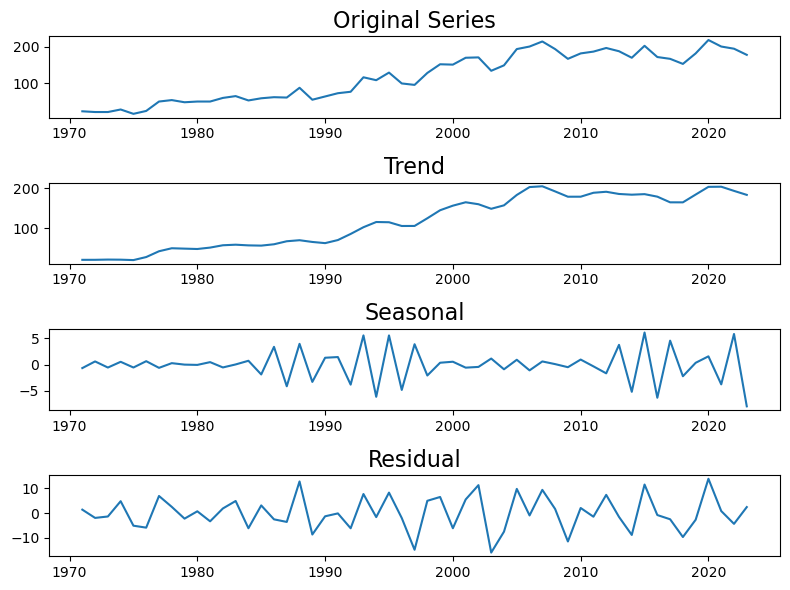

In [40]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(total_events_world)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend_events)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal_events)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid_events)
plt.title('Residual', fontsize=16)

plt.tight_layout( )

## Remove trend

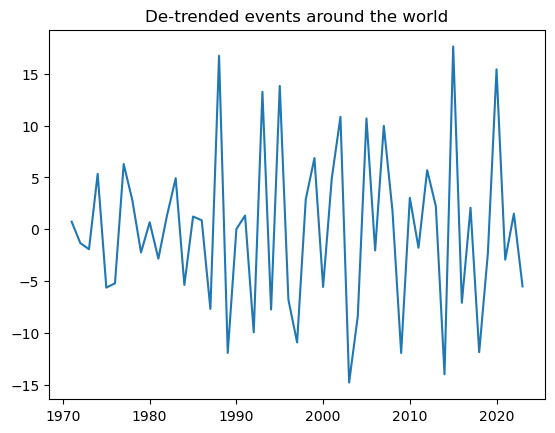

In [41]:
#Obtain de-trended
detrended_events = total_events_world.dropna().astype("float")["Total_events"] - trend_events.astype("float")

plt.plot(detrended_events)
plt.title("De-trended events around the world");

## ACF and PACF

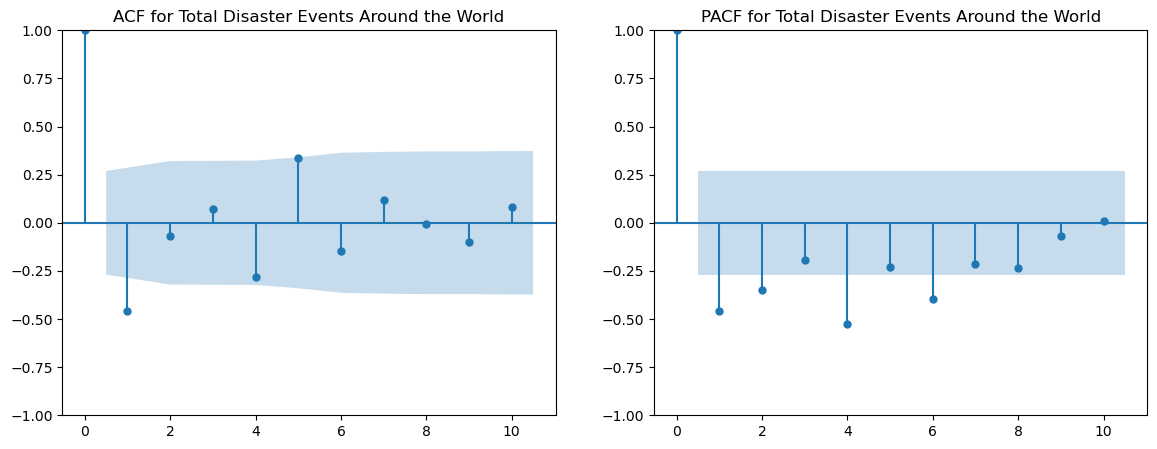

In [42]:
fig, ax= plt.subplots(1, 2, figsize = (14,5))
acf_plot = plot_acf(detrended_events.dropna(), lags = 10, ax = ax[0])
ax[0].set_title("ACF for Total Disaster Events Around the World");

pacf_plot = plot_pacf(detrended_events.dropna(), lags = 10, ax = ax[1])
ax[1].set_title("PACF for Total Disaster Events Around the World");

## Augmented Dickey Fuller test

By applying the Augmented Dickey-Fuller test to the de-trended version of the total disasters around the world, we reject the null hypothesis of unit root presence, and we can assume stationarity.

In [43]:
ADF_test_summary(pd.DataFrame(detrended_events).dropna().rename(columns={ 0: "Events"}) )

                                                    Events                                                    
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -6.578         -7.041        0.000          5    -4.166      -3.508     -3.184
	Constant             0.044          0.027        0.978
	Trend               -0.002         -0.033        0.974
Constant Only               -6.579         -7.134        0.000          5    -3.578      -2.925     -2.601
	Constant            -0.002         -0.002        0.998
No Constant                 -6.579         -7.231        0.000          5    -2.615      -1.948     -1.612


## Seasonality analysis

period_length is 2


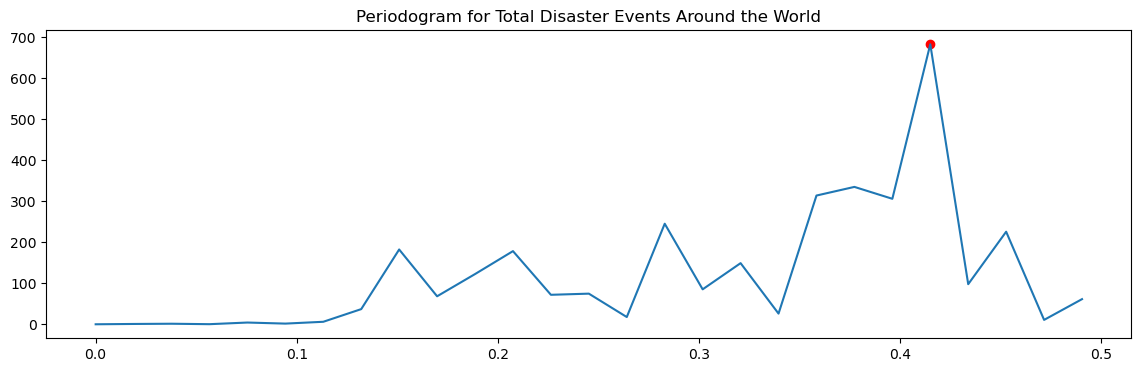

In [44]:
#Periodogram
f, Pxx = scipy.signal.periodogram(detrended_events.dropna())
max_power_index = np.argmax(Pxx)
dominant_frequency = f[max_power_index]
period_length = int(1 / dominant_frequency)

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(f, Pxx, label='Periodogram')
ax.scatter(f[max_power_index], Pxx[max_power_index], color='red', label=f'Dominant Frequency: {dominant_frequency:.2f} Hz')
plt.title("Periodogram for Total Disaster Events Around the World");

print("period_length is " +str(period_length))

# Total floods reported around the world

## Seasonal-trend decomposition 

In [45]:
stl_floods = STL( total_floods_world.dropna(), period = 2)
result_floods = stl_floods.fit()

In [46]:
trend_floods, seasonal_floods, resid_floods = result_floods.trend, result_floods.seasonal,  result_floods.resid

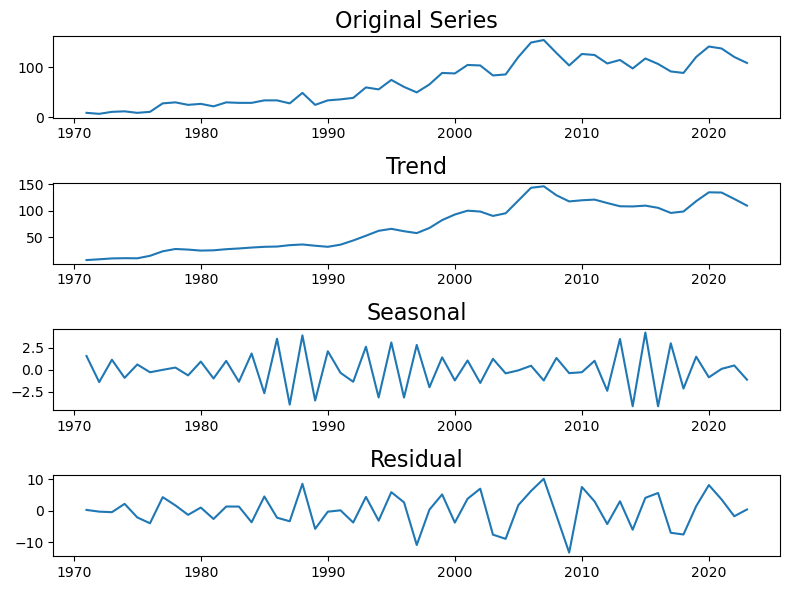

In [47]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(total_floods_world)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend_floods)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal_floods)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid_floods)
plt.title('Residual', fontsize=16)

plt.tight_layout( )

## Remove trend

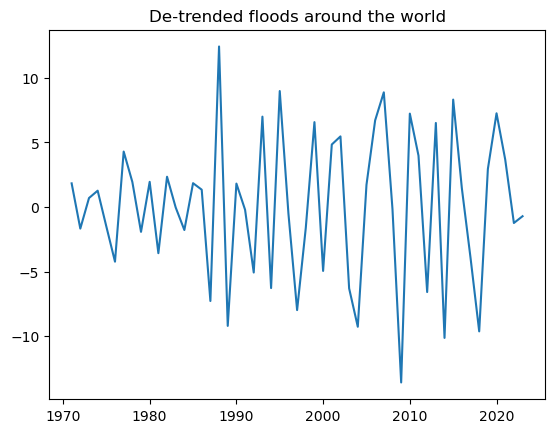

In [48]:
#Obtain de-trended
detrended_floods = total_floods_world.dropna().astype("float")["Flood"] - trend_floods.astype("float")

plt.plot(detrended_floods)
plt.title("De-trended floods around the world");

## ACF and PACF

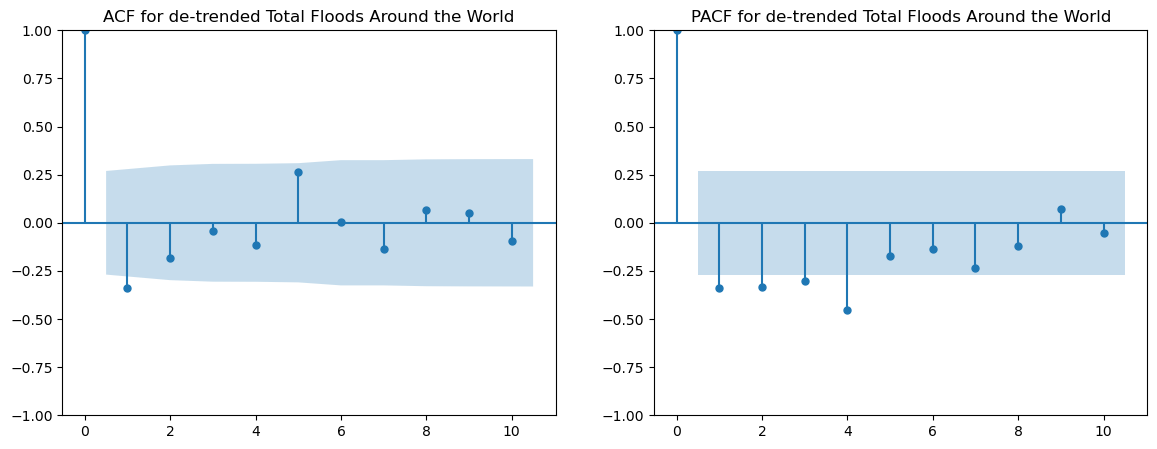

In [49]:
fig, ax= plt.subplots(1, 2, figsize = (14,5))
acf_plot = plot_acf(detrended_floods.dropna(), lags = 10, ax = ax[0])
ax[0].set_title("ACF for de-trended Total Floods Around the World");

pacf_plot = plot_pacf(detrended_floods.dropna(), lags = 10, ax = ax[1])
ax[1].set_title("PACF for de-trended Total Floods Around the World");

## Augmented Dickey Fuller test

By applying the Augmented Dickey-Fuller test to the de-trended version of the total floods around the world, we reject the null hypothesis of unit root presence, and we can assume stationarity.

In [50]:
ADF_test_summary(pd.DataFrame(detrended_floods).dropna().rename(columns={ 0: "Events"}))

                                                    Events                                                    
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -3.455         -7.820        0.000          3    -4.157      -3.504     -3.182
	Constant            -0.503         -0.369        0.714
	Trend                0.025          0.533        0.597
Constant Only               -3.445         -7.869        0.000          3    -3.571      -2.923     -2.599
	Constant             0.130          0.195        0.847
No Constant                 -3.443         -7.952        0.000          3    -2.613      -1.948     -1.612


## Seasonality analysis

period_length is 2


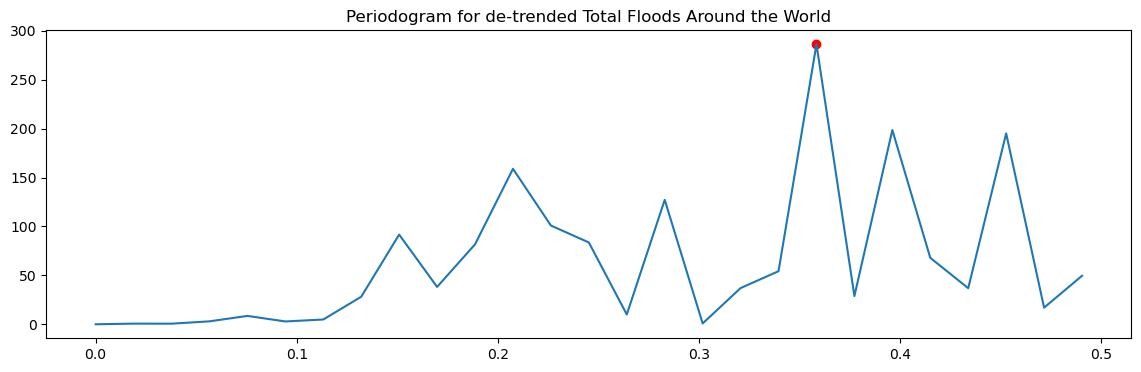

In [51]:
#Periodogram
f, Pxx = scipy.signal.periodogram(detrended_floods.dropna())
max_power_index = np.argmax(Pxx)
dominant_frequency = f[max_power_index]
period_length = int(1 / dominant_frequency)

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(f, Pxx, label='Periodogram')
ax.scatter(f[max_power_index], Pxx[max_power_index], color='red', label=f'Dominant Frequency: {dominant_frequency:.2f} Hz')
plt.title("Periodogram for de-trended Total Floods Around the World");

print("period_length is " +str(period_length))

# Total damages reported around the world

## Seasonal-trend decomposition 

In [52]:
stl_damages = STL( total_damages_world.dropna(), period = 2)
result_damages = stl_damages.fit()

In [53]:
trend_damages, seasonal_damages, resid_damages = result_damages.trend, result_damages.seasonal,  result_damages.resid

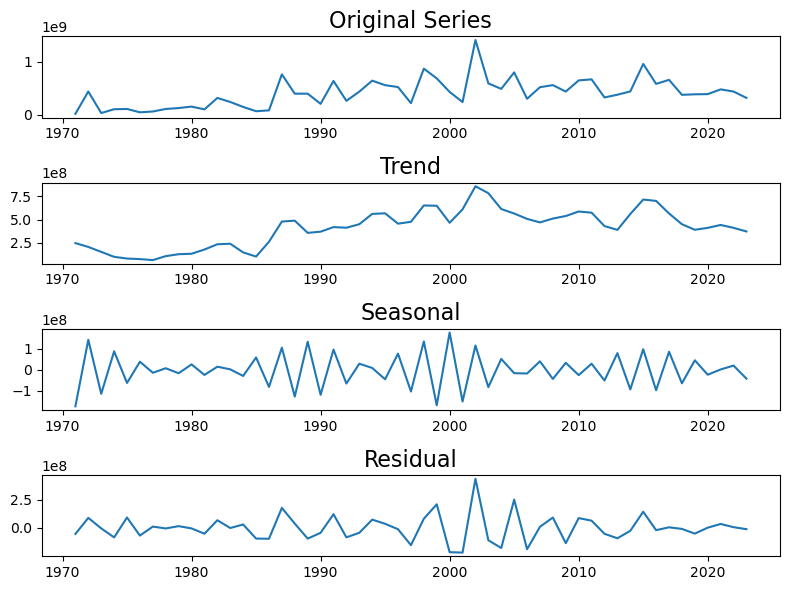

In [54]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(total_damages_world)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend_damages)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal_damages)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid_damages)
plt.title('Residual', fontsize=16)

plt.tight_layout( )

## Remove trend

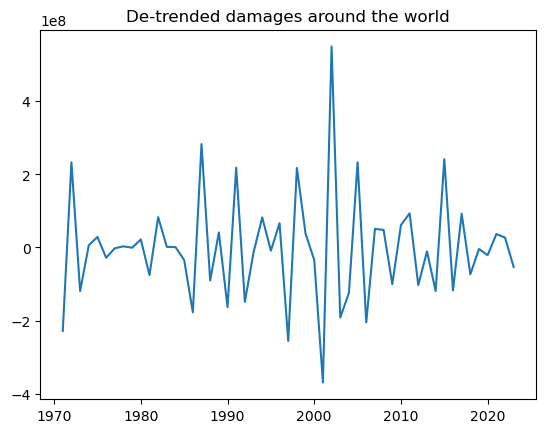

In [55]:
#Obtain de-trended
detrended_damages = total_damages_world.dropna().astype("float")["Total_damages"] - trend_damages.astype("float")

plt.plot(detrended_damages)
plt.title("De-trended damages around the world");

## ACF and PACF

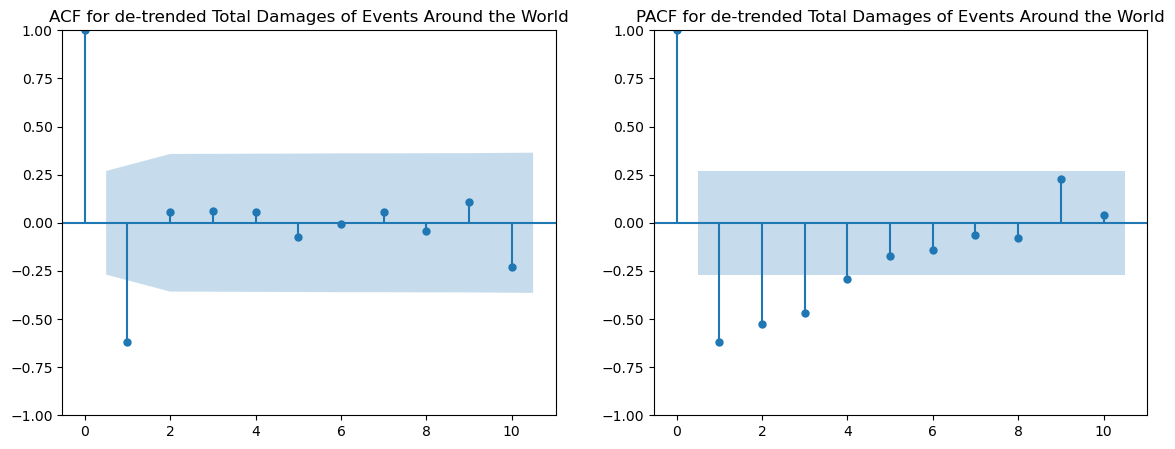

In [56]:
fig, ax= plt.subplots(1, 2, figsize = (14,5))
acf_plot = plot_acf(detrended_damages.dropna(), lags = 10, ax = ax[0])
ax[0].set_title("ACF for de-trended Total Damages of Events Around the World");

pacf_plot = plot_pacf(detrended_damages.dropna(), lags = 10, ax = ax[1])
ax[1].set_title("PACF for de-trended Total Damages of Events Around the World");

## Augmented Dickey Fuller test

By applying the Augmented Dickey-Fuller test to the de-trended version of the adjusted disaster damages around the world, we reject the null hypothesis of unit root presence, and we can assume stationarity.

In [57]:
ADF_test_summary(pd.DataFrame(detrended_damages).dropna().rename(columns={ 0: "Events"}))

                                                    Events                                                    
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend         -16.048         -6.313        0.000          7    -4.175      -3.513     -3.187
	Constant     -17848978.809         -0.778        0.442
	Trend           902458.586          1.028        0.311
Constant Only              -15.500         -6.231        0.000          7    -3.585      -2.928     -2.602
	Constant       2793096.674          0.251        0.803
No Constant                -15.474         -6.307        0.000          7    -2.617      -1.948     -1.612


## Seasonality analysis

period_length is 2


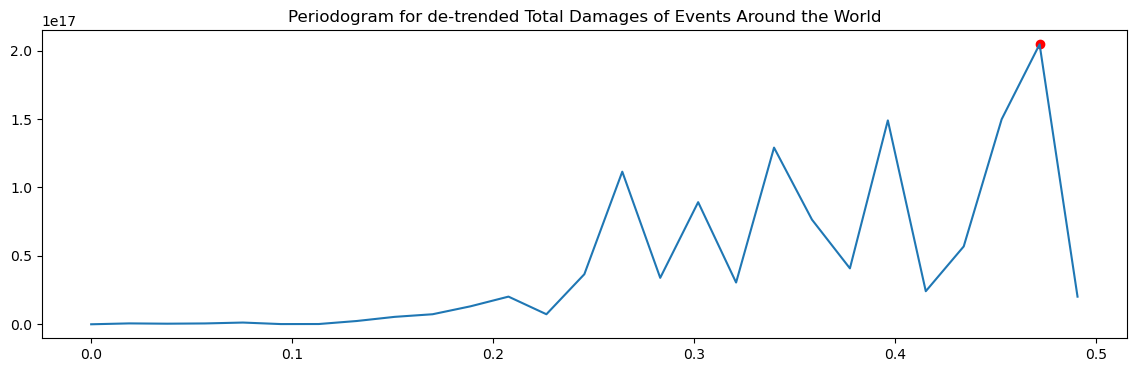

In [58]:
#Periodogram
f, Pxx = scipy.signal.periodogram(detrended_damages.dropna())
max_power_index = np.argmax(Pxx)
dominant_frequency = f[max_power_index]
period_length = int(1 / dominant_frequency)

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(f, Pxx, label='Periodogram')
ax.scatter(f[max_power_index], Pxx[max_power_index], color='red', label=f'Dominant Frequency: {dominant_frequency:.2f} Hz')
plt.title("Periodogram for de-trended Total Damages of Events Around the World");

print("period_length is " +str(period_length))

# Cointegration analysis

##  Johansen Cointegration Test

First, we apply the analysis for the level variables.
Using a 95% confidence level for the level variables, we reject the null hypothesis for all the possible numbers of cointegration relationships. 

Therefore we can conclude there is no cointegration between the variables.

In [59]:
#Define data 
data_coint = time_series[["co2","Temp", "precip"]].dropna()


coint_test_result = coint_johansen(data_coint, det_order = 1, k_ar_diff = 1)

#Cointegration test results
print("The trace statistic value for  a 95% confidence level is:" +  str( coint_test_result.trace_stat[1]))
print("The trace critical values for a 95% confidence level are:")
print(str(coint_test_result.trace_stat_crit_vals[1]))

print("The first column of the critical values represent the null hypothesis of no cointegration relation")
print("The second column of the critical values represent the null hypothesis that there is at most one cointegration relationship")
print("The third column of the critical values represent the null hypothesis that there is at most two cointegration relationships")

The trace statistic value for  a 95% confidence level is:10.040188937127775
The trace critical values for a 95% confidence level are:
[16.1619 18.3985 23.1485]
The first column of the critical values represent the null hypothesis of no cointegration relation
The second column of the critical values represent the null hypothesis that there is at most one cointegration relationship
The third column of the critical values represent the null hypothesis that there is at most two cointegration relationships


## Engle-Granger Cointegration Test for pairs of time series

### Co2 and Ocean Temperature 

In [60]:
y = time_series[["co2","Temp"]].dropna()["co2"].values
x = time_series[["co2","Temp"]].dropna()["Temp"].values
t_statistic, p_val, critical_p_val = coint(y,x)
print(f' t statistic: {np.round(t_statistic, 2)} \n p value: {np.round(p_val,2)} \n critical p values [1%, 5%, 10%]critical_p_val: {critical_p_val}')

 t statistic: -3.18 
 p value: 0.07 
 critical p values [1%, 5%, 10%]critical_p_val: [-4.07574874 -3.43326608 -3.11138281]


In this case, we do not observe cointegration for 5% and 1% significance levels, but we do for 10%

### Co2 and Precipitation

In [61]:
y = time_series[["co2","precip"]].dropna()["co2"].values
x = time_series[["co2","precip"]].dropna()["precip"].values
t_statistic, p_val, critical_p_val = coint(y,x)
print(f' t statistic: {np.round(t_statistic, 2)} \n p value: {np.round(p_val,2)} \n critical p values [1%, 5%, 10%]critical_p_val: {critical_p_val}')

 t statistic: -0.58 
 p value: 0.96 
 critical p values [1%, 5%, 10%]critical_p_val: [-4.19930068 -3.4972851  -3.15498702]


In this case, we do not observe cointegration at all between the two variables

### Precipitation and Ocean Temperature 

In [62]:
y = time_series[["precip","Temp"]].dropna()["precip"].values
x = time_series[["precip","Temp"]].dropna()["Temp"].values
t_statistic, p_val, critical_p_val = coint(y,x)
print(f' t statistic: {np.round(t_statistic, 2)} \n p value: {np.round(p_val,2)} \n critical p values [1%, 5%, 10%]critical_p_val: {critical_p_val}')

 t statistic: -5.31 
 p value: 0.0 
 critical p values [1%, 5%, 10%]critical_p_val: [-4.19930068 -3.4972851  -3.15498702]


In this case, we do not observe cointegration at all between the two variables